In [9]:
#Imports
from helpers import load_csv_data
from implementations import standardize, drop_features
from plots import visualize_filtered_data
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [28]:
# Step 1: Load the dataset
dir_path = '/Users/solenenoize/Desktop/data-dealers/dataset'
headers, x_train, x_test, y_train, train_ids, test_ids = load_csv_data(dir_path)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("train_ids shape: ", train_ids.shape)
print("test_ids shape: ", test_ids.shape)

x_train shape:  (328135, 321)
x_test shape:  (109379, 321)
y_train shape:  (328135,)
train_ids shape:  (328135,)
test_ids shape:  (109379,)


In [31]:
def drop_features(headers, data, constant_threshold=0.9, missing_threshold=0.9, correlation_threshold=0.95): 
    # Step 1: Identify columns to keep based on missing values and low variability
    columns_to_keep = []

    for i in range(data.shape[1]):
        # Calculate the percentage of missing values
        nan_ratio = np.isnan(data[:, i]).sum() / data.shape[0]

        # If more than `missing_threshold` of the column is NaN, consider it mostly missing and drop it
        if nan_ratio > missing_threshold:
            continue

        # Remove NaN values
        non_nan_values = data[:, i][~np.isnan(data[:, i])]
        unique_values = np.unique(non_nan_values)

        # Check if column has more than one unique value
        if len(unique_values) > 1:
            # Calculate the frequency of the most common value
            value_counts = Counter(non_nan_values)
            most_common_value, most_common_count = value_counts.most_common(1)[0]
            ratio = most_common_count / len(non_nan_values)

            # Keep column if it is not 90% constant
            if ratio < constant_threshold:
                columns_to_keep.append(i)

    # Step 2: Filter data and headers based on the identified columns to keep
    filtered_data = data[:, columns_to_keep]
    filtered_headers = [headers[i] for i in columns_to_keep]

    # Step 3: Drop highly correlated features (more than 95% correlation)
    corr_matrix = np.corrcoef(filtered_data, rowvar=False)
    corr_matrix = np.abs(corr_matrix)  # Take the absolute value of correlations

    # Create a boolean mask to identify highly correlated columns in the upper triangle
    num_features = corr_matrix.shape[0]
    correlated_features = set()

    for i in range(num_features):
        for j in range(i + 1, num_features):
            if corr_matrix[i, j] > correlation_threshold:
                correlated_features.add(j)

    # Get the indices of the columns to keep
    final_columns_to_keep = [i for i in range(num_features) if i not in correlated_features]

    # Filter data and headers based on the correlation threshold
    final_data = filtered_data[:, final_columns_to_keep]
    final_headers = [filtered_headers[i] for i in final_columns_to_keep]

    # Print number of dropped columns
    print(f"Dropped {data.shape[1] - len(final_headers)} columns that were either mostly missing, had low variability, or were highly correlated (>95%).")
    
    return final_headers, final_data, final_columns_to_keep

In [32]:
# Drop features from x_train and obtain the columns to keep
headers, x_train, columns_to_keep = drop_features(headers, x_train)

# Apply the same columns_to_keep to x_test to maintain consistency
x_test = x_test[:, columns_to_keep]

# Print the new dimensions of x_train after dropping columns
print(f"New shape of x_train after dropping columns: {x_train.shape}")
print(f"New shape of x_test after dropping columns: {x_test.shape}")

Dropped 146 columns that were either mostly missing, had low variability, or were highly correlated (>95%).
New shape of x_train after dropping columns: (328135, 175)
New shape of x_test after dropping columns: (109379, 175)


Missing Values Percentage per Feature:
Target       0.000000
_STATE       0.000000
FMONTH       0.000000
IDATE        0.000000
IMONTH       0.000000
              ...    
_RFSEAT2     0.000000
_RFSEAT3     0.000000
_FLSHOT6    64.417999
_PNEUMO2    64.417999
_AIDTST3     9.776464
Length: 194, dtype: float64


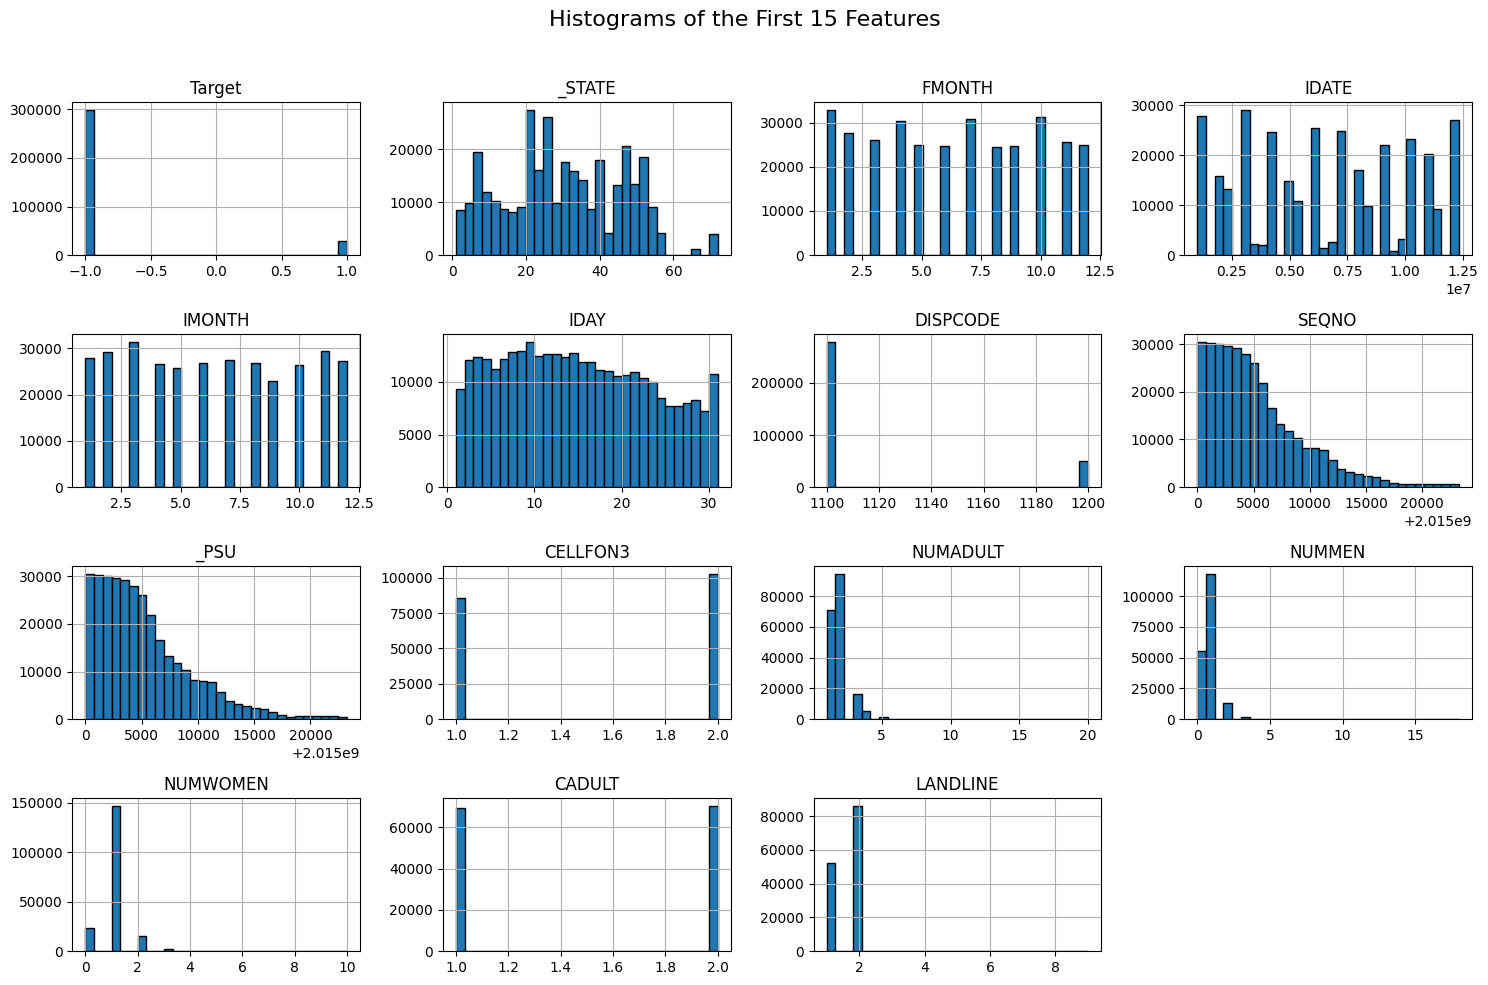

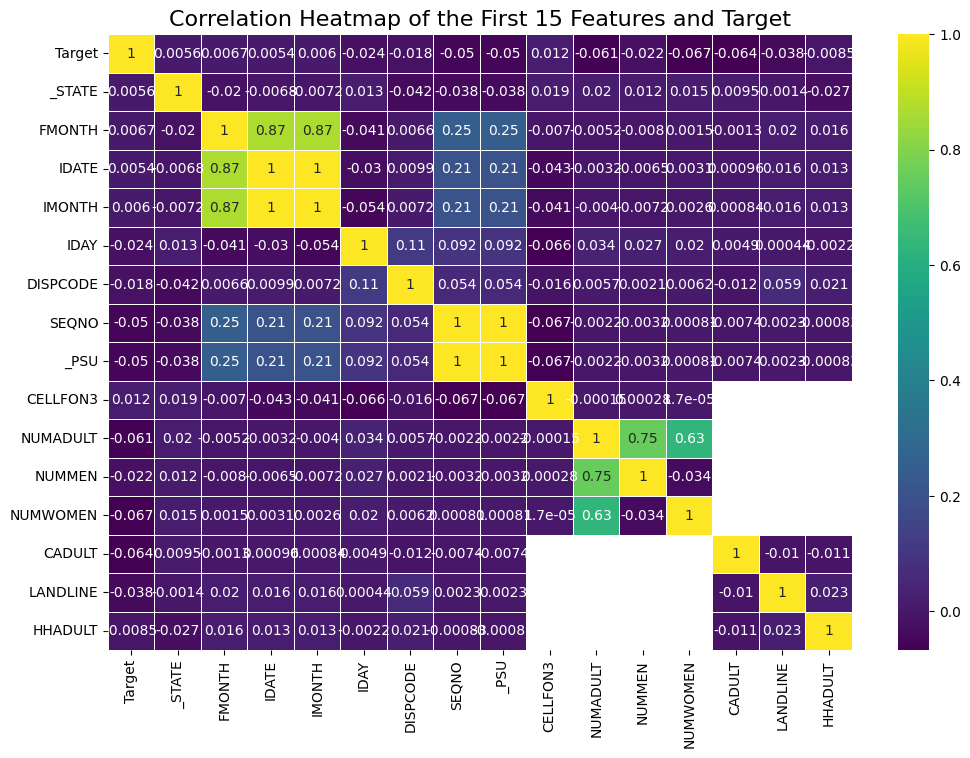

Number of features with correlation less than 20% with the target: 15
Features with correlation less than 20% with the target: ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'DISPCODE', 'SEQNO', '_PSU', 'CELLFON3', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CADULT', 'LANDLINE', 'HHADULT']


In [26]:
def visualize_filtered_data(headers, data, y):
    """
    Visualize the dataset after dropping columns.

    Args:
        headers (list): List of feature names.
        data (np.array): The filtered dataset (x_train_filtered).
        y (np.array): The target variable.
    """
    # Convert data to a DataFrame for easier manipulation and visualization
    df = pd.DataFrame(data, columns=headers)

    # Add target variable to the beginning of the DataFrame
    df.insert(0, 'Target', y)

    # Step 1: Check for missing values in percentage for each column
    missing_values_percentage = df.isna().mean() * 100
    print("Missing Values Percentage per Feature:")
    print(missing_values_percentage)

    # Step 2: Plot histograms for all features
    df.hist(bins=30, figsize=(20, 15), edgecolor='black')
    plt.suptitle("Histograms of All Features", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Step 3: Correlation heatmap to visualize relationships between all features and target
    plt.figure(figsize=(12, 8))
    corr_matrix = df.corr()  # Include target variable in correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5)
    plt.title("Correlation Heatmap of Features and Target", fontsize=16)
    plt.show()

    # Step 4: Print the number of features that are less than 20% correlated with the target
    target_corr = corr_matrix['Target'].drop('Target')
    low_corr_features = target_corr[abs(target_corr) < 0.2]
    print(f"Number of features with correlation less than 20% with the target: {len(low_corr_features)}")
    print(f"Features with correlation less than 20% with the target: {list(low_corr_features.index)}")
    
visualize_filtered_data(headers, x_train, y_train)